# Análisis exploratorio y estadístico (EDA)
En este notebook realizamos un análisis exploratorio de los datos de peleadores, centrado en la **visualización y comparación de variables clave** como la categoría de peso, el número de golpes significativos por minuto (SLpM), la altura y el peso.

El objetivo es:
- Explorar distribuciones de variables numéricas.
- Comparar estadísticas entre categorías.
- Identificar posibles relaciones o diferencias significativas mediante pruebas estadísticas.


## Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ttest_ind 
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import jinja2


# Configuración general
plt.style.use('default')
sns.set_palette("husl")

## Carga de datos
Cargamos los datos ya transformados de la capa **Silver**, que contienen la información limpia y estructurada de los peleadores.

A partir de este DataFrame trabajaremos directamente con las variables de interés para el análisis exploratorio.

In [29]:
# Ruta relativa (subimos un nivel desde /notebooks hasta la raíz del proyecto)
bronze_path = os.path.join(os.curdir, "..", "data", "bronze")
silver_path = os.path.join(os.curdir, "..", "data", "silver")
reports_path = os.path.join(os.curdir, "..", "reports")
figures_path = os.path.join(reports_path, "figures")

# Nombres de archivos parquet
bronze_file_name = "fighter_details_bronze.parquet"
silver_file_name = "fighter_details_silver.parquet"

# Construimos rutas completas
bronze_file_path = os.path.join(bronze_path, bronze_file_name)
silver_file_path = os.path.join(silver_path, silver_file_name)

# Creamos carpetas si no existen
os.makedirs(silver_path, exist_ok=True)
os.makedirs(figures_path, exist_ok=True)

## Descripción del DataFrame

El DataFrame `silver_df` contiene la información detallada de los peleadores del UFC recopilada desde distintas fuentes oficiales.  
Cada fila representa un **peleador único**, y cada columna describe una característica física o estadística de su desempeño.  

A continuación se detalla el significado de cada variable:

### Identificación y datos personales
- **fighter_name** → Nombre completo del peleador.   
- **Age** → Edad actual del peleador (en años).  
- **Height(cm)** → Altura expresada en centímetros.  
- **Weigh(lbs)** → Peso en libras.  
- **Weight_Class** → Categoría de peso oficial del peleador (por ejemplo: Flyweight, Bantamweight, Featherweight, Lightweight, etc.).
- **Stance** → Tipo de guardia o postura de combate:
  - *Orthodox*: diestro (pie izquierdo adelante, golpe fuerte con la derecha).  
  - *Southpaw*: zurdo (pie derecho adelante, golpe fuerte con la izquierda).  
  - *Switch*: alterna entre ambas guardias.  
  - *Open Stance / Sideways / Other*: estilos menos comunes o híbridos.  

### Estadísticas de combate (rendimiento ofensivo y defensivo)
- **SLpM** *(Significant Strikes Landed per Minute)* → Promedio de golpes significativos conectados por minuto.  
- **Str_Acc(%)** *(Striking Accuracy)* → Porcentaje de precisión en los golpes lanzados.  
- **SApM** *(Significant Strikes Absorbed per Minute)* → Promedio de golpes significativos recibidos por minuto.  
- **Str_Def(%)** *(Striking Defense)* → Porcentaje de golpes significativos evitados o bloqueados.  

### Estadísticas de grappling (agarres y derribos)
- **TD_Avg** *(Takedown Average)* → Promedio de derribos (takedowns) completados por 15 minutos de combate.  
- **TD_Acc(%)** *(Takedown Accuracy)* → Porcentaje de éxito en los intentos de derribo.  
- **TD_Def(%)** *(Takedown Defense)* → Porcentaje de defensa exitosa ante intentos de derribo del rival.  
- **Sub_Avg** *(Submission Average)* → Promedio de intentos de sumisión por 15 minutos.  

In [30]:
silver_df = pd.read_parquet(silver_file_path)
display(silver_df)

,fighter_name,Height(cm),Weight(lbs),Weight_Class,Stance,Age,SLpM,Str_Acc(%),SApM,Str_Def(%),TD_Avg,TD_Acc(%),TD_Def(%),Sub_Avg,_BronzeTimestamp,_SilverTimestamp
0,Papy Abedi,180,185,Middleweight,Southpaw,42,2.80,55.0,3.15,48.0,3.47,57.0,50.0,1.3,2025-11-10 13:49:51.311624,2025-11-10 20:39:06.925614
1,Shamil Abdurakhimov,190,235,Heavyweight,Orthodox,39,2.45,44.0,2.45,58.0,1.23,24.0,47.0,0.2,2025-11-10 13:49:51.311624,2025-11-10 20:39:06.925614
2,Danny Abbadi,180,155,Lightweight,Orthodox,37,3.29,38.0,4.41,57.0,0.00,0.0,77.0,0.0,2025-11-10 13:49:51.311624,2025-11-10 20:39:06.925614
3,Ricardo Abreu,180,185,Middleweight,Orthodox,36,3.79,31.0,3.98,68.0,2.13,42.0,100.0,0.7,2025-11-10 13:49:51.311624,2025-11-10 20:39:06.925614
4,Daichi Abe,180,170,Welterweight,Orthodox,29,3.80,33.0,4.49,56.0,0.33,50.0,0.0,0.0,2025-11-10 13:49:51.311624,2025-11-10 20:39:06.925614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,Errol Zimmerman,190,185,Middleweight,Orthodox,34,2.95,42.0,0.00,0.0,0.00,0.0,0.0,0.0,2025-11-10 13:49:51.311624,2025-11-10 20:39:06.925614
2381,Cat Zingano,168,145,Featherweight,Southpaw,38,2.57,61.0,1.63,47.0,2.77,65.0,42.0,0.8,2025-11-10 13:49:51.311624,2025-11-10 20:39:06.925614
2382,Joao Zeferino,180,170,Welterweight,Orthodox,35,0.83,36.0,2.60,48.0,0.50,5.0,50.0,1.0,2025-11-10 13:49:51.311624,2025-11-10 20:39:06.925614
2383,Zhang Tiequan,173,155,Lightweight,Orthodox,42,1.23,36.0,2.14,51.0,1.95,58.0,75.0,3.4,2025-11-10 13:49:51.311624,2025-11-10 20:39:06.925614


## Distribución de peleadores por categoría de peso
Comenzamos visualizando cuántos peleadores pertenecen a cada categoría de peso.

Esto nos ayuda a ver cuáles son las categorías de peso con mayor número de peleadores.


Weight_Class
Welterweight         403
Lightweight          392
Middleweight         314
Featherweight        286
Bantamweight         266
Heavyweight          246
Light Heavyweight    240
Flyweight            162
Strawweight           76
Name: count, dtype: int64

/var/folders/q8/x_yglj357yg0btc9y0jf5wmh0000gn/T/ipykernel_88195/1073075999.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=silver_df, x='Weight_Class', order=order_wc,palette="husl")


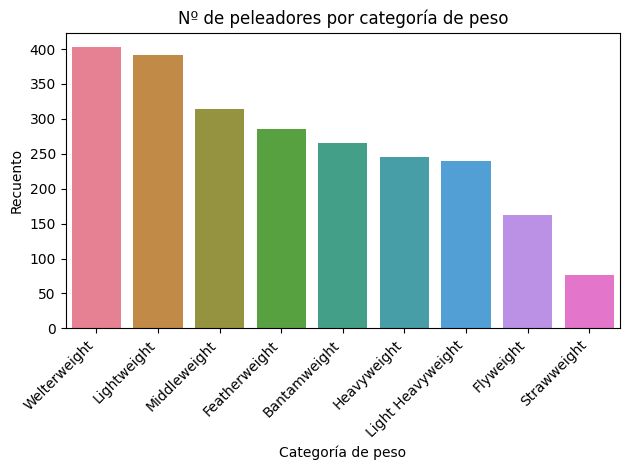

In [31]:
# Contamos cuántos peleadores hay por categoría de peso y ordenamos de mayor a menor
wc_counts = silver_df['Weight_Class'].value_counts().sort_values(ascending=False)

# Mostramos la tabla de frecuencias en pantalla
display(wc_counts)

# Guardamos el orden de las categorías según su frecuencia
order_wc = wc_counts.index  # orden por frecuencia

# Creamos el gráfico de barras con Seaborn (countplot)
ax = sns.countplot(data=silver_df, x='Weight_Class', order=order_wc,palette="husl")

# Añadimos título y etiquetas a los ejes
ax.set_title('Nº de peleadores por categoría de peso')
ax.set_xlabel('Categoría de peso')
ax.set_ylabel('Recuento')

# Rotamos las etiquetas del eje X para que no se monten
plt.xticks(rotation=45, ha='right')

# Ajusta automáticamente los márgenes del gráfico
plt.tight_layout()

# Guardamos el gráfico en la carpeta de figuras
plt.savefig(os.path.join(figures_path, "count_by_weight_class.png"), dpi=150)

# Mostramos el gráfico en el notebook
plt.show()

## Distribución de peleadores por tipo de guardia
Visualizamos cuántos peleadores pertenecen a tipo de guardia.

Esto nos ayuda a detectar que tipos de guardias son las más comunes dentro de la UFC.


Stance
Orthodox       1835
Southpaw        433
Switch          111
Open Stance       5
Sideways          1
Name: count, dtype: int64

/var/folders/q8/x_yglj357yg0btc9y0jf5wmh0000gn/T/ipykernel_88195/2760177811.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=silver_df, x='Stance', order=order_st,palette="husl")


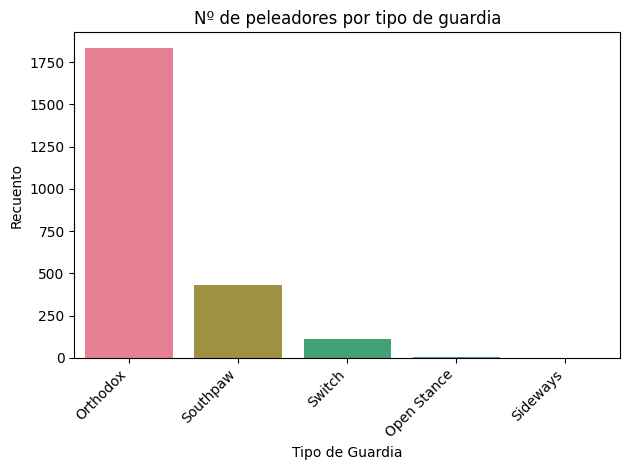

In [32]:
# Contamos cuántos peleadores hay por tipo de guardia y ordenamos de mayor a menor
st_counts = silver_df['Stance'].value_counts().sort_values(ascending=False)

# Mostramos la tabla de frecuencias en pantalla
display(st_counts)

# Guardamos el orden de las categorías según su frecuencia
order_st = st_counts.index  # orden por frecuencia

# Creamos el gráfico de barras con Seaborn (countplot)
ax = sns.countplot(data=silver_df, x='Stance', order=order_st,palette="husl")

# Añadimos título y etiquetas a los ejes
ax.set_title('Nº de peleadores por tipo de guardia')
ax.set_xlabel('Tipo de Guardia')
ax.set_ylabel('Recuento')

# Rotamos las etiquetas del eje X para que no se monten
plt.xticks(rotation=45, ha='right')

# Ajusta automáticamente los márgenes del gráfico
plt.tight_layout()

# Guardamos el gráfico en la carpeta de figuras
plt.savefig(os.path.join(figures_path, "count_by_stance.png"), dpi=150)

# Mostramos el gráfico en el notebook
plt.show()

## Histograma de distintas estadísticas (distribución e interpretación)
Representamos la distribución de `SLpM`, `SApM`, `Str_Acc(%)`, `Str_Def (%)`, `TD_Def (%)`,`TD_Acc (%)`,`TD_Avg`, `Sub_Avg`
para identificar **forma de la distribución**, **asimetrías (sesgo)** y **posibles colas largas/outliers**.

Este gráfico complementa a las estadísticas descriptivas:
- Si la distribución es aproximadamente **normal**, la **media** y la **mediana** estarán cercanas.
- Si hay **sesgo positivo** (cola a la derecha), la **media > mediana** y conviene usar la **mediana** como centro robusto.
- Una **desviación estándar** alta sugiere mayor dispersión; si se debe a pocos outliers, valorar **IQR** o **MAD**.


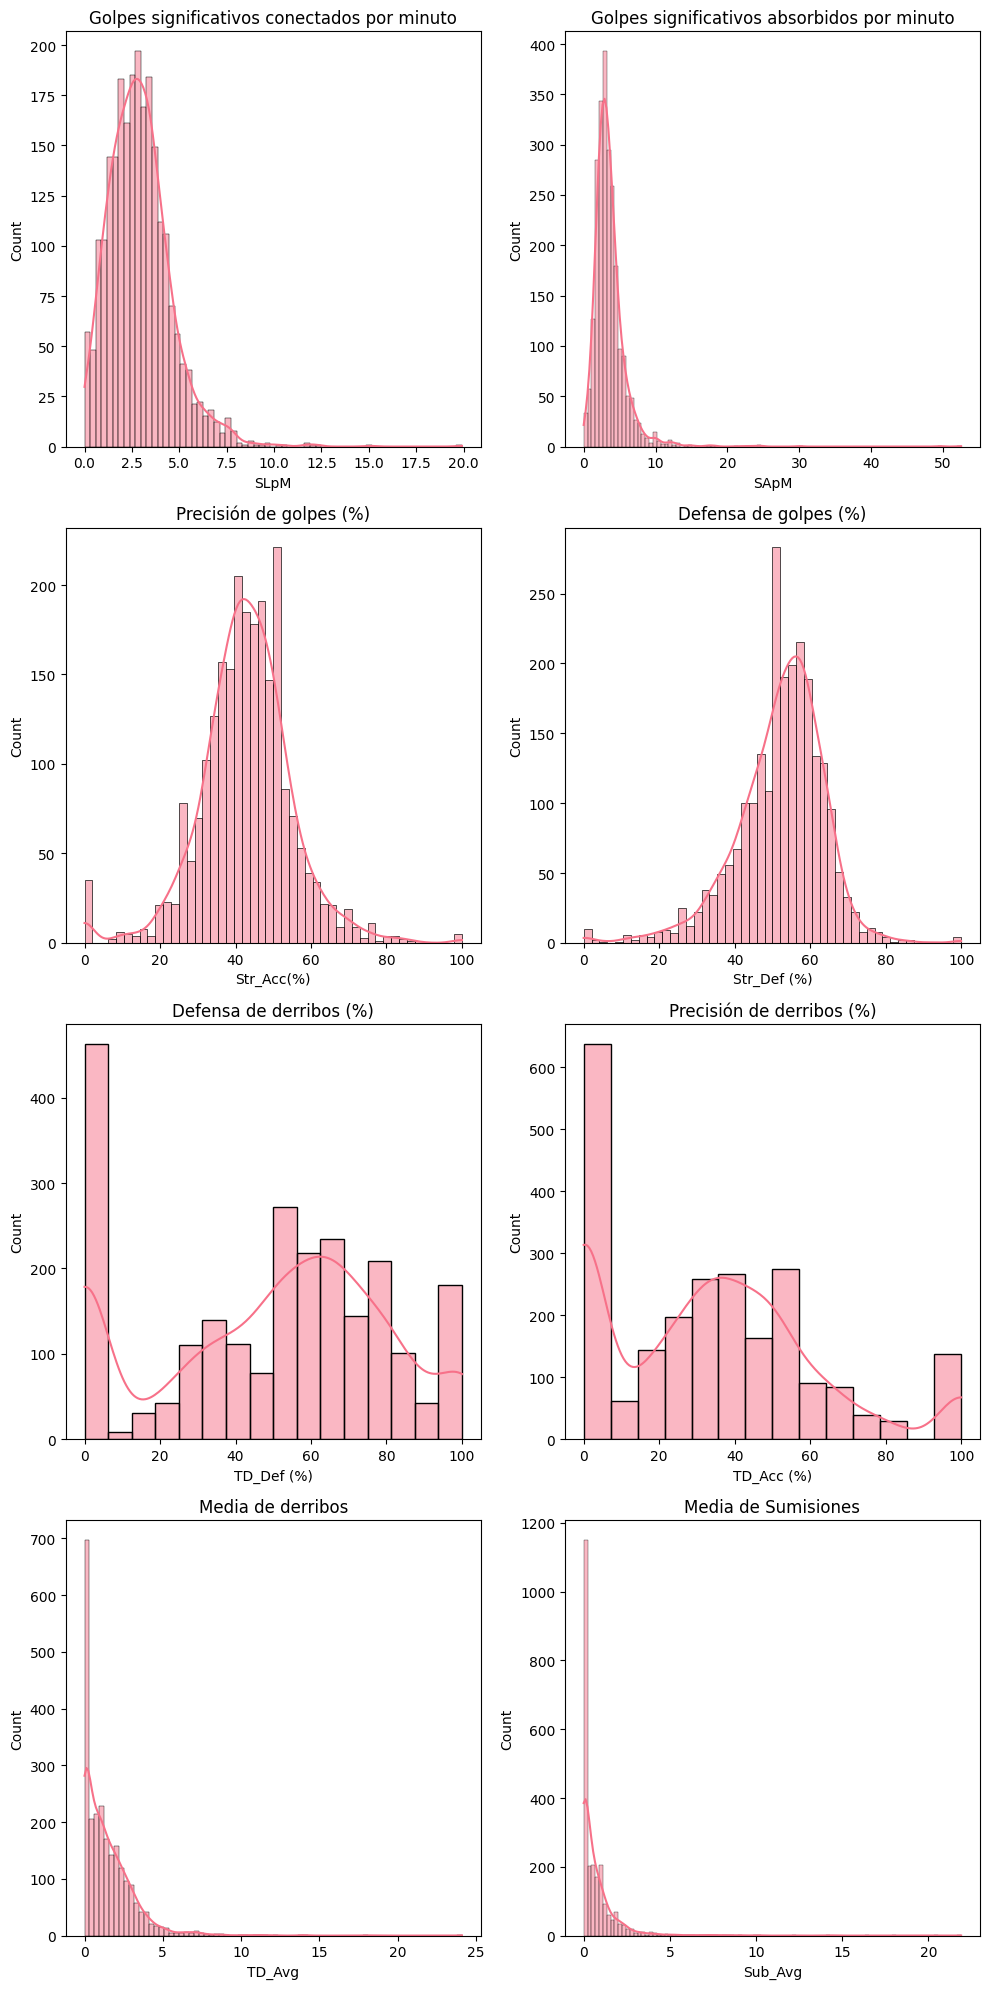

In [33]:
# Creamos una figura con 8 subgráficos (4 filas x 2 columnas)
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
axes = axes.ravel() # "aplana" la matriz de ejes para acceder con un solo índice

# SLpM
#Dibuja un histograma de la variable
sns.histplot(silver_df['SLpM'], kde=True, ax=axes[0]) #kde=True añade una curva de densidad que suaviza la distribución.

#Se configura título y etiqueta del eje X.
axes[0].set_title('Golpes significativos conectados por minuto')
axes[0].set_xlabel('SLpM')

# SApM
sns.histplot(silver_df['SApM'], kde=True, ax=axes[1])
axes[1].set_title('Golpes significativos absorbidos por minuto')
axes[1].set_xlabel('SApM')

# Precisión de golpes (%)
sns.histplot(silver_df['Str_Acc(%)'], kde=True, ax=axes[2])
axes[2].set_title('Precisión de golpes (%)')
axes[2].set_xlabel('Str_Acc(%)')

# Defensa de golpes (Str_Def%)
sns.histplot(silver_df['Str_Def(%)'], kde=True, ax=axes[3])
axes[3].set_title('Defensa de golpes (%)')
axes[3].set_xlabel('Str_Def (%)')

# Defensa de derribos (TD_Def%)
sns.histplot(silver_df['TD_Def(%)'], kde=True, ax=axes[4])
axes[4].set_title('Defensa de derribos (%)')
axes[4].set_xlabel('TD_Def (%)')

# Precisión de derribos (TD_Acc%)
sns.histplot(silver_df['TD_Acc(%)'], kde=True, ax=axes[5])
axes[5].set_title('Precisión de derribos (%)')
axes[5].set_xlabel('TD_Acc (%)')

# Media de derribos (TD_Avg)
sns.histplot(silver_df['TD_Avg'], kde=True, ax=axes[6])
axes[6].set_title('Media de derribos')
axes[6].set_xlabel('TD_Avg')

# Defensa de golpes (Sub_Avg)
sns.histplot(silver_df['Sub_Avg'], kde=True, ax=axes[7])
axes[7].set_title('Media de Sumisiones')
axes[7].set_xlabel('Sub_Avg')

# Guardamos la figura completa con todos los histogramas
plt.savefig(os.path.join(figures_path, "count_by_Stats.png"), dpi=150)
plt.tight_layout() # Ajusta márgenes para evitar solapamientos
plt.show()



## Media global vs medias por categoría
Contrastamos la **media global de (UFC)** con las **medias por `Weight_Class`** para ver rápidamente qué categorías se sitúan **por encima** o **por debajo** del promedio global.



In [34]:
# Creamos una copia del dataframe original para trabajar sin modificar el original
silver_df = silver_df.copy()

# Seleccionamos las métricas de rendimiento
metrics = ['SLpM','SApM','Str_Acc(%)','Str_Def(%)','TD_Avg','TD_Acc(%)','TD_Def(%)','Sub_Avg']

# Medias por categoría de peso
weight_means = (
    silver_df.groupby('Weight_Class', dropna=False, observed=False)[metrics] # agrupamos por categoría de peso
      .mean() # calculamos la media de cada métrica dentro de cada grupo
      .round(2) # redondeamos los valores a 2 decimales para facilitar la lectura
      .sort_index() # ordenamos las categorías alfabéticamente (puedes cambiar por sort_values() si prefieres por valor)
)

# Media total (toda la UFC)
# Calculamos la media general de todas las métricas sin agrupar
ufc_mean = pd.DataFrame(silver_df[metrics].mean().round(2)).T # .T = transpuesta, para que las métricas queden como columnas
ufc_mean.index = ['UFC_Total'] # Renombramos la fila como "UFC_Total" para distinguirla

# Mostramos los resultados formateados
# Usamos .style para aplicar formato visual:
# - background_gradient colorea las celdas según el valor (más alto = más intenso)
# - set_caption añade un título encima de la tabla
display(ufc_mean.style.background_gradient(cmap='Greens').set_caption("Media total (UFC completa)"))
display(weight_means.style.background_gradient(cmap='Oranges').set_caption("Medias por categoría de peso"))


,SLpM,SApM,Str_Acc(%),Str_Def(%),TD_Avg,TD_Acc(%),TD_Def(%),Sub_Avg
UFC_Total,2.930000,3.630000,42.730000,52.120000,1.440000,33.200000,48.860000,0.710000


,SLpM,SApM,Str_Acc(%),Str_Def(%),TD_Avg,TD_Acc(%),TD_Def(%),Sub_Avg
Weight_Class,,,,,,,,
Strawweight,3.640000,4.580000,44.080000,52.430000,1.230000,33.620000,50.580000,0.530000
Flyweight,3.370000,3.650000,42.090000,55.650000,1.380000,33.780000,50.490000,0.630000
Bantamweight,3.110000,3.840000,41.270000,54.180000,1.390000,30.630000,50.830000,0.570000
Featherweight,3.290000,3.700000,42.890000,54.450000,1.530000,32.880000,53.620000,0.620000
Lightweight,2.750000,3.340000,40.750000,53.660000,1.500000,32.830000,49.240000,0.800000
Welterweight,2.820000,3.460000,41.980000,52.250000,1.440000,36.210000,50.920000,0.680000
Middleweight,2.680000,3.500000,43.740000,50.530000,1.600000,36.500000,46.440000,0.850000
Light Heavyweight,2.830000,3.740000,45.340000,49.080000,1.470000,29.420000,45.150000,0.820000
Heavyweight,2.650000,3.820000,44.640000,47.140000,1.200000,31.020000,42.350000,0.700000


## Relación entre variables numéricas
A continuación, exploramos la **correlación** entre variables numéricas como **altura**, frente a **peso y golpes significativos conectados por minuto** para entender si existe una relación lineal entre ellas.

La correlación de Pearson mide la fuerza y dirección de la relación:
- +1 → relación positiva perfecta.
- 0 → sin relación lineal.
- -1 → relación negativa perfecta.


Matriz de correlación (Pearson):


,Height(cm),Weight(lbs)
Height(cm),1.000000,0.769806
Weight(lbs),0.769806,1.000000


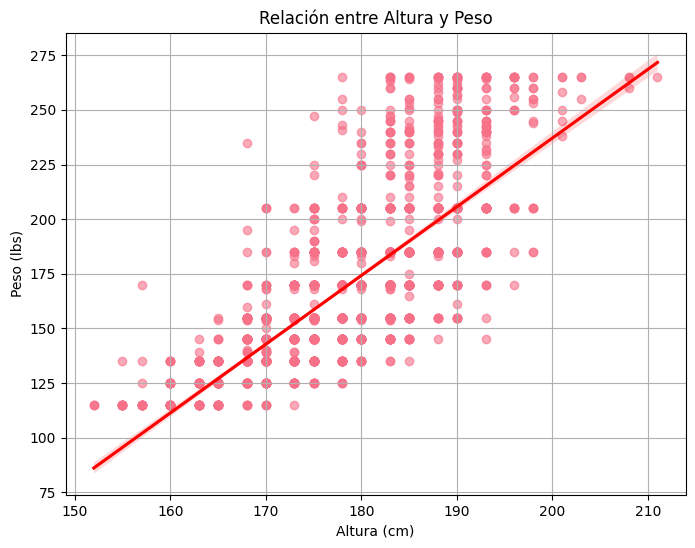

In [35]:
# Calculamos la correlación de Pearson entre la altura (cm) y el peso (lbs)
correlacion1 = silver_df[['Height(cm)', 'Weight(lbs)']].corr(method='pearson')

# Mostramos la matriz de correlación resultante
# (2x2, donde el valor fuera de la diagonal indica la relación entre ambas variables)
print("Matriz de correlación (Pearson):")
display(correlacion1)

# Creamos una figura con tamaño definido
plt.figure(figsize=(8,6))

# Usamos un gráfico de dispersión (regplot) con línea de regresión
sns.regplot(
    data=silver_df,
    x='Height(cm)', # variable en eje X → altura
    y='Weight(lbs)', # variable en eje Y → peso
    scatter_kws={'alpha':0.6}, # alpha reduce opacidad de los puntos (mejor visibilidad)
    line_kws={'color':'red'} # color rojo para la línea de tendencia
)

# Añadimos título y etiquetas de los ejes
plt.title('Relación entre Altura y Peso')
plt.xlabel('Altura (cm)')
plt.ylabel('Peso (lbs)')

# Añadimos una cuadrícula de fondo para facilitar la lectura
plt.grid(True)

# Guardamos el gráfico como imagen PNG dentro de la carpeta de figuras
plt.savefig(os.path.join(figures_path, "relation_bt_Height_Weight.png"), dpi=150)

# Mostramos el gráfico en pantalla
plt.show()

Matriz de correlación (Pearson):


,Height(cm),Str_Acc(%)
Height(cm),1.000000,0.108257
Str_Acc(%),0.108257,1.000000


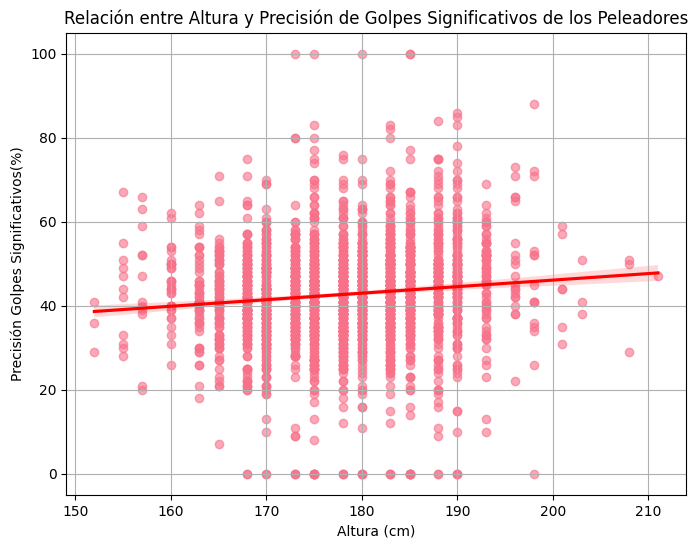

In [36]:
# Calculamos la correlación de Pearson entre la altura (cm) y el precisión en el striking(%)
correlacion2 = silver_df[['Height(cm)', 'Str_Acc(%)']].corr(method='pearson')

# Mostramos la matriz de correlación resultante
# (2x2, donde el valor fuera de la diagonal indica la relación entre ambas variables)
print("Matriz de correlación (Pearson):")
display(correlacion2)

# Creamos una figura con tamaño definido
plt.figure(figsize=(8,6))

# Usamos un gráfico de dispersión (regplot) con línea de regresión
sns.regplot(
    data=silver_df,
    x='Height(cm)', # variable en eje X → altura
    y='Str_Acc(%)', # variable en eje Y → precisión en el striking
    scatter_kws={'alpha':0.6}, # alpha reduce opacidad de los puntos (mejor visibilidad)
    line_kws={'color':'red'} # color rojo para la línea de tendencia
)

# Añadimos título y etiquetas de los ejes
plt.title('Relación entre Altura y Precisión de Golpes Significativos de los Peleadores')
plt.xlabel('Altura (cm)')
plt.ylabel('Precisión Golpes Significativos(%)')

# Añadimos una cuadrícula de fondo para facilitar la lectura
plt.grid(True)

# Guardamos el gráfico como imagen PNG dentro de la carpeta de figuras
plt.savefig(os.path.join(figures_path, "relation_bt_Height_Str_Acc.png"), dpi=150)

# Mostramos el gráfico en pantalla
plt.show()

## Comparación entre dos categorías: prueba t-test
Cuando queremos comparar **dos grupos concretos**, usamos la **prueba t de Student (t-test)**.

Esta prueba evalúa si la **diferencia entre las medias** de `Stance` **Orthodox** y **Southpaw** es **estadísticamente significativa**.

Supuestos del t-test:
- Las dos muestras son independientes.
- La variable sigue una distribución aproximadamente normal en cada grupo.
- Las varianzas entre grupos son similares (puede comprobarse con Levene).

Interpretación del resultado:
- **p-valor < 0.05 → diferencia significativa** entre grupos.
- **t-stat positivo** → la primera categoría tiene una media mayor.
- **t-stat negativo** → la segunda categoría tiene una medi


In [37]:
# Filtramos los dos grupos: Orthodox y Southpaw
orthodox = silver_df[silver_df['Stance'] == 'Orthodox']['Str_Acc(%)']
southpaw = silver_df[silver_df['Stance'] == 'Southpaw']['Str_Acc(%)']

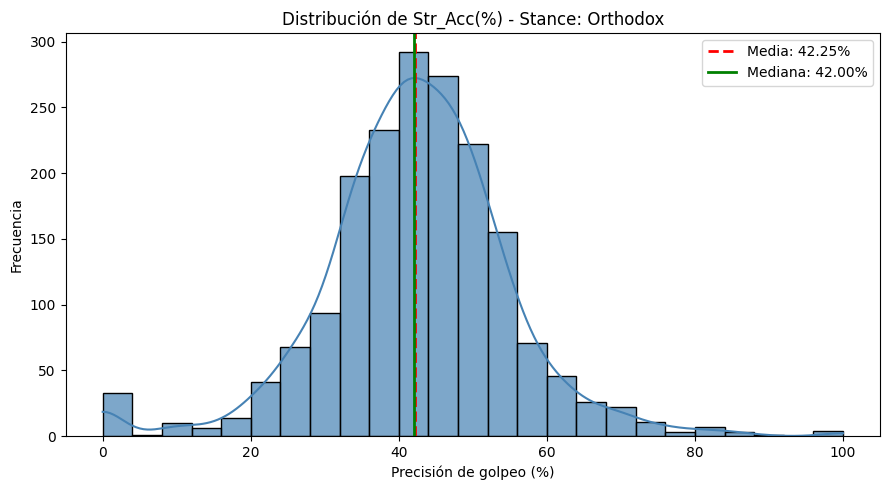

In [38]:
# Creamos el histograma con KDE
plt.figure(figsize=(9,5))
ax = sns.histplot(orthodox, bins=25, kde=True, color='steelblue', edgecolor='black', alpha=0.7)

# Añadimos líneas de media y mediana
mean_val = orthodox.mean()
median_val = orthodox.median()
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}%')
ax.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Mediana: {median_val:.2f}%')

# Etiquetas y título
ax.set_title('Distribución de Str_Acc(%) - Stance: Orthodox')
ax.set_xlabel('Precisión de golpeo (%)')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_path, "Dist_Str_Acc_Othodox.png"), dpi=150)
plt.show()

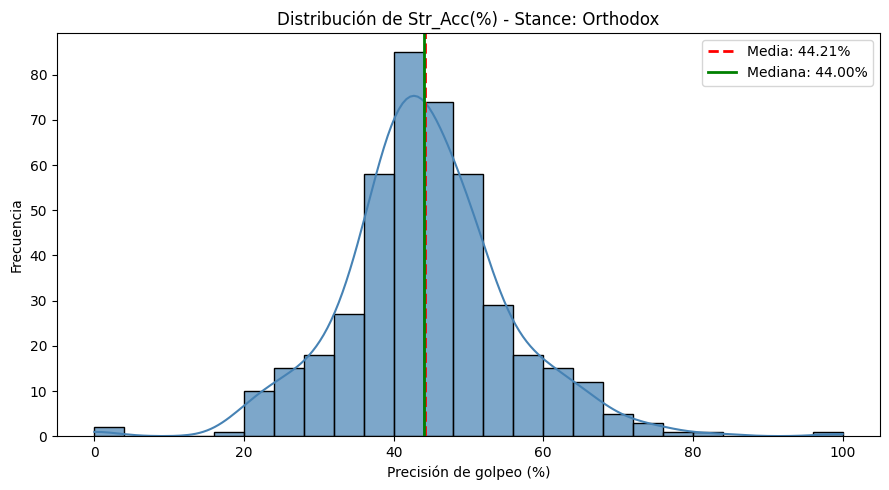

In [ ]:
# Creamos el histograma con KDE
plt.figure(figsize=(9,5))
ax = sns.histplot(southpaw, bins=25, kde=True, color='steelblue', edgecolor='black', alpha=0.7)

# Añadimos líneas de media y mediana
mean_val = southpaw.mean()
median_val = southpaw.median()
ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.2f}%')
ax.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Mediana: {median_val:.2f}%')

# Etiquetas y título
ax.set_title('Distribución de Str_Acc(%) - Stance: Southpaw')
ax.set_xlabel('Precisión de golpeo (%)')
ax.set_ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_path, "Dist_Str_Acc_Southpaw.png"), dpi=150)
plt.show()

In [39]:
# Test t de muestras independientes
t_stat, p_val = ttest_ind(orthodox, southpaw, equal_var=False)  # Welch t-test

# Mostramos resultados
print(f"t = {t_stat:.3f}")
print(f"p = {p_val:.4f}")

# Interpretación básica
if p_val < 0.05:
    print("Diferencia significativa entre Orthodox y Southpaw (rechazamos H₀).")
    if t_stat>0:
        print("Los Orthodox tienen más porcentaje de acierto que los Southpaw")
    else:
        print("Los Southpaw tienen más porcentaje de acierto que los Orthodox")
else:
    print(" No hay evidencia suficiente de diferencia significativa (no se rechaza H₀).")
    

t = -3.197
p = 0.0015
Diferencia significativa entre Orthodox y Southpaw (rechazamos H₀).
Los Southpaw tienen más porcentaje de acierto que los Orthodox


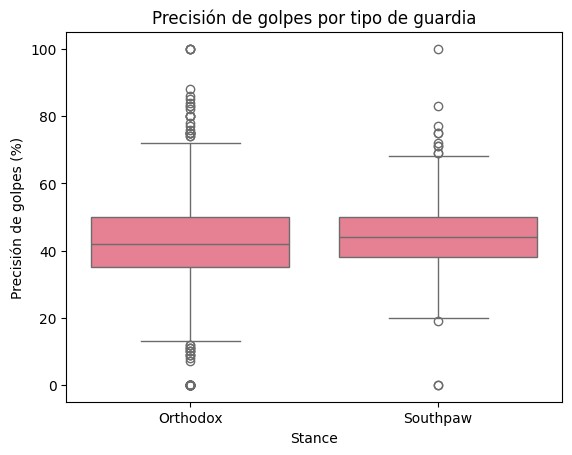

Media Orthodox: 42.25 %
Media Southpaw: 44.21 %


In [40]:
# Creamos un gráfico de caja (boxplot) que compara la precisión de golpes (%)
# entre peleadores de guardia Orthodox y Southpaw
sns.boxplot(data=silver_df, 
            x='Stance', # variable categórica → tipo de guardia
            y='Str_Acc(%)', # variable numérica → precisión de golpes (%)
            order=['Orthodox','Southpaw'] # orden explícito de las categorías en el eje X
)

# Añadimos título y etiquetas a los ejes
plt.title('Precisión de golpes por tipo de guardia')
plt.xlabel('Stance')
plt.ylabel('Precisión de golpes (%)')

# Guardamos la figura como imagen PNG en la carpeta de figuras
plt.savefig(os.path.join(figures_path, "Str_Acc_Othodox_Southpaw.png"), dpi=150)

# Mostramos el gráfico en el notebook
plt.show()

# Imprimimos la media de precisión para cada tipo de guardia
print("Media Orthodox:", orthodox.mean().round(2),"%")
print("Media Southpaw:", southpaw.mean().round(2),"%")

## Comparación estadística entre categorías (ANOVA)
Para comprobar si las diferencias observadas entre categorías son **estadísticamente significativas**, aplicamos un **ANOVA (Analysis of Variance)**.

Este test evalúa si al menos una categoría tiene una media de `SLpM` diferente a las demás.
Un **p-valor < 0.05** indica que existe diferencia significativa entre grupos.


In [41]:
# ANOVA de un factor: comparación del SLpM entre categorías de peso

# Creamos una copia del DataFrame original para no modificarlo directamente
silver_df = silver_df.copy()

# Creamos una lista que contiene, para cada categoría de peso,
# todos los valores de "SLpM" (golpes significativos por minuto)
# Solo se incluyen categorías que tienen más de un peleador (len(group) > 1)
groups = [group['SLpM'].values for name, group in silver_df.groupby('Weight_Class')]

# Ejecución del ANOVA de un factor
# f_oneway() compara las medias de más de dos grupos (aquí, las divisiones de peso)
# para ver si hay diferencias estadísticamente significativas entre ellas
f_stat, p_val = f_oneway(*groups)

# Resultados del test
# Imprimimos el estadístico F (relación entre la variabilidad entre grupos y dentro de grupos)
# y el valor p (nivel de significancia)
print(f"F = {f_stat:.3f}")
print(f"p = {p_val:.4f}")

# Interpretamos los resultados:
# Si p < 0.05 → hay diferencias significativas entre al menos dos categorías de peso
# Si p ≥ 0.05 → no hay evidencia suficiente para afirmar que las medias difieran
if p_val < 0.05:
    print(" Diferencias significativas entre categorías de peso (rechazamos H₀).")
else:
    print(" No se detectan diferencias significativas entre categorías (no se rechaza H₀).")


F = 7.961
p = 0.0000
 Diferencias significativas entre categorías de peso (rechazamos H₀).


/var/folders/q8/x_yglj357yg0btc9y0jf5wmh0000gn/T/ipykernel_88195/3839972929.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['SLpM'].values for name, group in silver_df.groupby('Weight_Class')]


## Test post-hoc de Tukey
Tras detectar diferencias globales con ANOVA, aplicamos el **test de Tukey HSD (Honestly Significant Difference)** para identificar **qué grupos concretos difieren entre sí**.

El resultado muestra:
- `meandiff`: diferencia media entre grupos.
- `p-adj`: p-valor ajustado.
- `reject`: indica si la diferencia es significativa (True / False).


In [43]:
# Test post-hoc de Tukey (HSD)

# Aplicamos el test de Tukey Honestly Significant Difference (HSD)
# Este test se usa después del ANOVA cuando hemos encontrado diferencias significativas,
# y sirve para identificar entre qué pares de grupos existen esas diferencias.
tukey = pairwise_tukeyhsd(
    endog=silver_df['SLpM'],         # Variable dependiente (valores numéricos a comparar → golpes por minuto)
    groups=silver_df['Weight_Class'],# Variable categórica que define los grupos → categorías de peso
    alpha=0.05                # Nivel de significancia (5%)
)

# Mostramos un resumen tabulado con los resultados de todas las comparaciones por pares
print(tukey.summary())

#Interpretamos los resultados:
# Si reject = True, esas dos categorías de peso tienen medias de SLpM significativamente distintas.
# Si reject = False, no hay evidencia de diferencia en el promedio de golpes por minuto entre ellas.


           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------------
     Bantamweight     Featherweight   0.1782 0.9429 -0.2614  0.6178  False
     Bantamweight         Flyweight   0.2525 0.8445 -0.2619  0.7668  False
     Bantamweight       Heavyweight  -0.4646 0.0424 -0.9212 -0.0081   True
     Bantamweight Light Heavyweight   -0.288 0.5815 -0.7475  0.1715  False
     Bantamweight       Lightweight  -0.3655 0.1255 -0.7755  0.0445  False
     Bantamweight      Middleweight   -0.439 0.0412 -0.8691 -0.0089   True
     Bantamweight       Strawweight   0.5282 0.2611 -0.1431  1.1995  False
     Bantamweight      Welterweight  -0.2932 0.3846 -0.7009  0.1145  False
    Featherweight         Flyweight   0.0742    1.0 -0.4333  0.5817  False
    Featherweight       Heavyweight  -0.6428 0.0003 -1.0916 -0.1941   True
    Featherweight Light H

## Distribución de golpes significativos por minuto (SLpM) según categoría
En esta sección analizamos cómo varía el promedio de golpes significativos por minuto (`SLpM`) en función de la **categoría de peso**.

Utilizamos un **boxplot** complementado con un **stripplot** para observar tanto la distribución general como los puntos individuales, lo que facilita detectar posibles **outliers o diferencias entre grupos**.


/var/folders/q8/x_yglj357yg0btc9y0jf5wmh0000gn/T/ipykernel_88195/2578544392.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


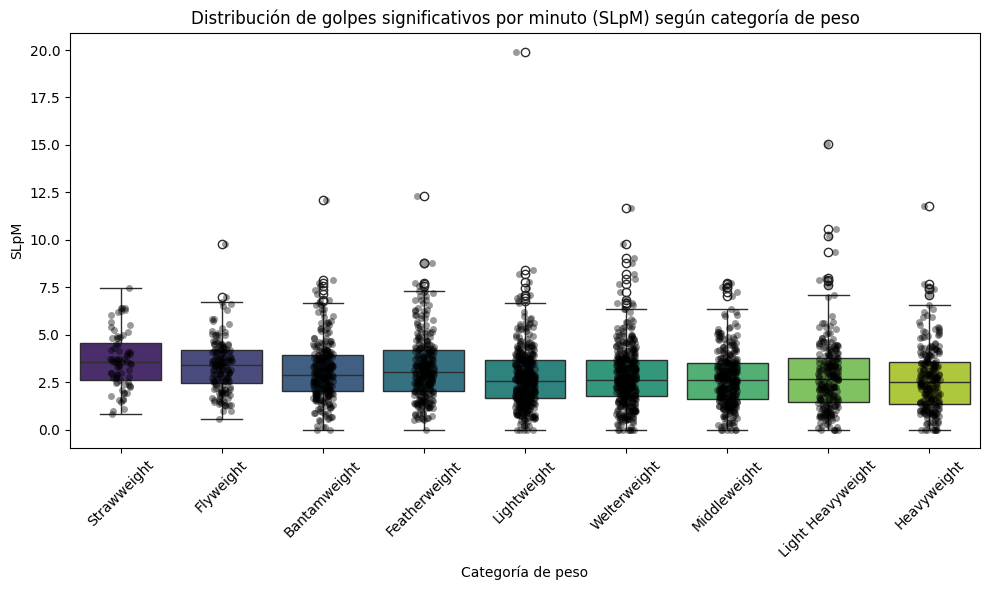

In [44]:
#Visualización Boxplot del SLpM por categoría de peso

# Creamos la figura del gráfico y definimos su tamaño (ancho x alto)
plt.figure(figsize=(10,6))

# Boxplot principal
sns.boxplot(
    data=silver_df,
    x='Weight_Class',   # variable categórica → eje X (categorías de peso)
    y='SLpM',           # variable numérica → eje Y (golpes significativos por minuto)
    palette='viridis'   # paleta de colores para diferenciar las cajas
)

# Puntos individuales (stripplot)
sns.stripplot(
    data=silver_df,
    x='Weight_Class',   # misma variable categórica → eje X
    y='SLpM',           # misma métrica numérica
    color='black',      # color de los puntos
    alpha=0.4,          # transparencia (para ver la densidad de puntos)
    jitter=True         # añade desplazamiento horizontal aleatorio → evita solapamientos
)

# Títulos y etiquetas
plt.title('Distribución de golpes significativos por minuto (SLpM) según categoría de peso')
plt.xlabel('Categoría de peso')
plt.ylabel('SLpM')

# Rota las etiquetas del eje X para que se lean mejor
plt.xticks(rotation=45)

# Ajusta automáticamente los márgenes del gráfico para que no se corten etiquetas
plt.tight_layout()

# Guarda la figura como imagen PNG dentro de la carpeta de figuras
plt.savefig(os.path.join(figures_path, "SLpM_Weight_Class.png"), dpi=150)

# Muestra el gráfico en pantalla
plt.show()
